## Importing Libraries and Functions

In [1]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras import models
from keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.image import rgb_to_grayscale
from tensorflow import reshape
from tensorflow.image import resize_with_pad
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import numpy as np
from imgaug import augmenters as iaa
import imgaug as ia

%matplotlib inline

In [2]:
sys.path[0] = '/Users/nicksubic/Documents/flatiron/phase_1/nyc-mhtn-ds-091420-lectures/Phase_4/Pnuemonia-image-classification/src/modules/'
import graphs
import data

## Importing the Data

In [3]:
images = data.import_image_to_array('/../../../chest_xray/',
         dir_names = ['train', 'test', 'val'],
         sub_dir_names = ['NORMAL', 'PNEUMONIA'],
         padding=False,
         shape=(224,224), test=False, grayscale = False)

Your relative directory is good, proceeding to import files...

Loading images from train
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from test
Finished loading images from NORMAL
Finished loading images from PNEUMONIA

Loading images from val
Finished loading images from NORMAL
Finished loading images from PNEUMONIA



### Splitting the train, test and validation data into just image arrays for modeling

In [6]:
X_train = np.array([i[1] for i in images['train']])  
y_train = np.array([i[2] for i in images['train']])

X_test = np.array([i[1] for i in images['test']])
y_test = np.array([i[2] for i in images['test']])

X_val = np.array([i[1] for i in images['val']])
y_val = np.array([i[2] for i in images['val']])

### Creating a simple baseline CNN model with 2 Convolution layers, 1 densely connected and no regularization

In [5]:
#baseline model- two convolution layers, maxpooling, one 32 node dense layer and the output

cnn = models.Sequential()

# Input convolution layer
cnn.add(layers.Conv2D(64, kernel_size= (3, 3), activation='relu', input_shape=(224, 224,  3)))

# Max pooling layer
cnn.add(layers.MaxPooling2D((2, 2)))

# Hidden convolution layer and pool
cnn.add(layers.Conv2D(32, kernel_size= (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))

# Output
cnn.add(layers.Dense(1, activation='sigmoid'))

# Compiling with stochastic gradient descent, optimized for accuracy
cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [6]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=50,
                    validation_data=(X_val, y_val))

Epoch 1/5
105/105 [==============================] - 150s 1s/step - loss: 0.5063 - acc: 0.7648 - val_loss: 1.3311 - val_acc: 0.5000
Epoch 2/5
105/105 [==============================] - 136s 1s/step - loss: 0.3731 - acc: 0.8370 - val_loss: 0.5043 - val_acc: 0.8125
Epoch 3/5
105/105 [==============================] - 136s 1s/step - loss: 0.2753 - acc: 0.8905 - val_loss: 0.4259 - val_acc: 0.8125
Epoch 4/5
105/105 [==============================] - 142s 1s/step - loss: 0.1989 - acc: 0.9183 - val_loss: 0.7032 - val_acc: 0.5625
Epoch 5/5
105/105 [==============================] - 135s 1s/step - loss: 0.1697 - acc: 0.9371 - val_loss: 0.4399 - val_acc: 0.8125


In [7]:
results_test = cnn.evaluate(X_test, y_test)

20/20 [==============================] - 4s 197ms/step - loss: 0.5827 - acc: 0.7692


In [8]:
# Confusion Matrix functions
def get_labels(fit_model, X, threshold):
    return [1 if x >= threshold else 0 for x in fit_model.predict(X)]
def get_false_positive(true, prediction):
    return [1 if (x == 0 and y == 1) else 0 for x,y in zip(true,prediction)]
def get_true_positive(true, prediction):
    return [1 if (x == 1 and y == 1) else 0 for x,y in zip(true,prediction)]
def get_false_negative(true, prediction):
    return [1 if (x == 1 and y == 0) else 0 for x,y in zip(true,prediction)]

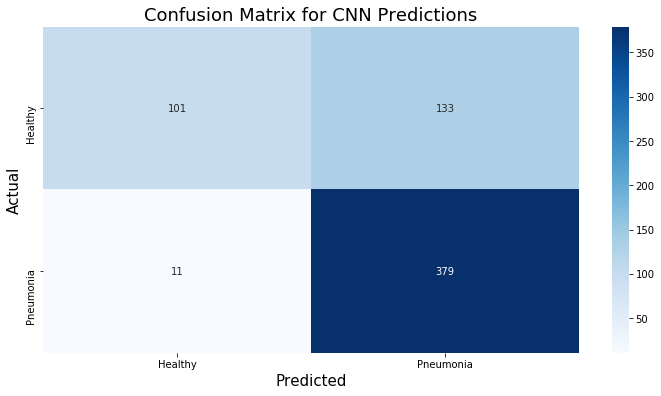

In [9]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(cnn, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

## Creating a more optimized model

#### Next, we created a much more complex model. We expanded our metrics from just Accuracy to adding AUC and Recall. We changed our optimizer to Adam in order to reduce improve our learning rate. We created overlaps in our pools, added regularization layers and increased the number of graduated dense layers. We also calculated the inverse class frequency to further compensate for our class imbalance.

In [7]:
# calculate inverse 
pnue_frequency = sum(y_train)/len(y_train)
inv_pnue_frequency = 1/pnue_frequency
normal_frequency = (len(y_train)-sum(y_train))/len(y_train)
inv_normal_frequency = 1/normal_frequency
weights = {
    0: inv_normal_frequency,
    1: inv_pnue_frequency
    }

In [8]:
# Setting an early stop feature
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

rms = tf.keras.optimizers.RMSprop(learning_rate=0.1)

cnn2 = models.Sequential()
# Input convolution layers
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Overlapped pooling
cnn2.add(layers.MaxPooling2D((2, 3)))

# First hidden convolution layers and pool
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 3)))

# Second hidden convolution layers and pools
cnn2.add(layers.Conv2D(16, (6, 6), activation='relu'))
cnn2.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 3)))

# Flatten layer
cnn2.add(layers.Flatten())

# 3 Graduated densely connected layers with graduated regularization
cnn2.add(layers.Dense(64, activation='relu'))
cnn2.add(layers.Dropout(.5))
cnn2.add(layers.Dense(32, activation='relu'))
cnn2.add(layers.Dropout(.3))
cnn2.add(layers.Dense(16, activation='relu'))
cnn2.add(layers.Dropout(.1))

# Output layer
cnn2.add(layers.Dense(1, activation='sigmoid'))
cnn2.compile(loss='binary_crossentropy',
              optimizer= 'Adam',
              metrics=['acc', 'Recall', 'AUC'])

# Fitting the model with our additional class weight parameter
cnn3 = cnn2.fit(X_train, y_train,
               epochs=20,
               batch_size=50,
               validation_data = (X_val, y_val), 
               class_weight=weights,
               verbose=True,
               callbacks = callback)

Epoch 1/20
105/105 [==============================] - 441s 4s/step - loss: 1.3880 - acc: 0.4306 - recall: 0.3737 - auc: 0.4917 - val_loss: 0.6931 - val_acc: 0.5000 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/20
105/105 [==============================] - 432s 4s/step - loss: 1.3865 - acc: 0.7373 - recall: 0.9866 - auc: 0.4908 - val_loss: 0.6931 - val_acc: 0.5000 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
105/105 [==============================] - 402s 4s/step - loss: 1.3865 - acc: 0.3117 - recall: 0.1159 - auc: 0.4950 - val_loss: 0.6931 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 4/20
105/105 [==============================] - 403s 4s/step - loss: 1.3864 - acc: 0.5817 - recall: 0.6684 - auc: 0.4976 - val_loss: 0.6932 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 5/20
105/105 [==============================] - 405s 4s/step - loss: 1.3880 - acc: 0.3869 - recall: 0.2686 - auc: 0.5234 - val_loss: 0.6587 - val_acc: 0.6875 - val_recall: 0.

In [9]:
#evaluating the model on the test set

results_test2 = cnn2.evaluate(X_test, y_test)

20/20 [==============================] - 12s 593ms/step - loss: 1.2493 - acc: 0.7885 - recall: 0.9821 - auc: 0.8473


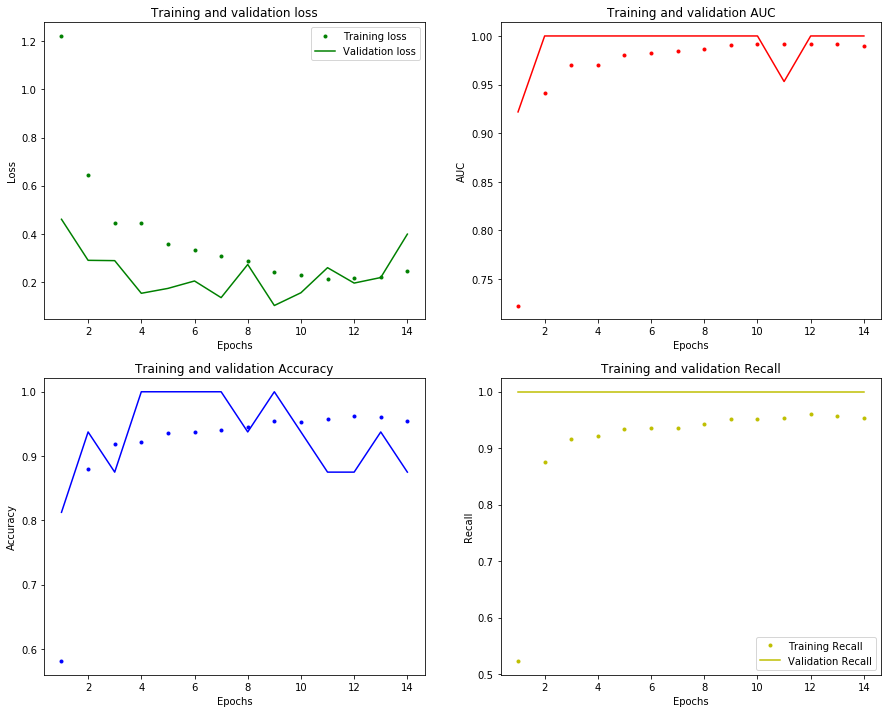

In [12]:
# Plotting the progress by epoch

graphs.plot_loss(cnn3.history)

In [ ]:
# Generating a confusion matrix from the model predictions

predictions = graphs.get_labels(cnn2, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

In [ ]:
# Plotting the ROC curve of our predictions

graphs.plot_roc_curve(y_test, cnn2.predict(X_test))

## Transfer Learning

Though our initial results are looking good, we decided to bring in some pre-trained models and try to use them in conjuction- both to get ideas about the architecture that could work the best for us and to possibly use a stacking classifier to combine a variety of models for the best possible result.

### VGG16

In [ ]:
VGG16_model = VGG16(input_shape = (224, 224, 3), 
                    # Shape of our images
                    include_top = False, 
                    # Leave out the last fully connected layer
                    weights = 'imagenet')

for layer in VGG16_model.layers:
    layer.trainable = False
#making the existing layers untrainable in order to preserve them

# Flatten the output layer to 1 dimension
x = layers.Flatten()(VGG16_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a second fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Dropout with a rate of 0.3
x = layers.Dropout(.3)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

vggmodel = tf.keras.models.Model(VGG16_model.input, x)

vggmodel.compile(optimizer = 'Adam', 
              loss = 'binary_crossentropy',
              metrics = ['acc', 'Recall', 'AUC'])

vgghist = vggmodel.fit(X_train, y_train, 
                       validation_data = (X_val, y_val), 
                       epochs = 10, 
                       batch_size=50, 
                       class_weight=weights, 
                       callbacks= callback)

In [ ]:
# evaluating the model on the test set

results_test3 = vggmodel.evaluate(X_test, y_test)

In [ ]:
#Plotting loss by epoch

graphs.plot_loss(vgghist.history)

In [ ]:
# Generating a confusion matrix from the model predictions

predictions = graphs.get_labels(vggmodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

In [ ]:
# Plotting the ROC curve of our predictions

graphs.plot_roc_curve(y_test, vggmodel.predict(X_test))

### DenseNet121

In [ ]:
densebase = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='Max',
    classes=2,)

for layer in densebase.layers:
    layer.trainable = False

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Flatten the output layer to 1 dimension
a = layers.Flatten()(densebase.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
a = layers.Dense(512, activation='relu')(a)

# Add a dropout rate of 0.5
a = layers.Dropout(0.5)(a)

# Add a second fully connected layer with 256 hidden units and ReLU activation
a = layers.Dense(256, activation='relu')(a)

a = layers.Dropout(.3)(a)
# Add a final sigmoid layer for classification
a = layers.Dense(1, activation='sigmoid')(a)

densemodel = tf.keras.models.Model(densebase.input, a)

densemodel.compile(optimizer = 'sgd', loss = 'binary_crossentropy',metrics = ['acc', 'Recall', 'AUC'])

densehist = densemodel.fit(
                      X_train, y_train, 
                      validation_data = (X_val, y_val), 
                      epochs = 25, 
                      batch_size=25, 
                      class_weight=weights)

In [ ]:
# evaluating the model on the test set

results_test4 = densemodel.evaluate(X_test, y_test)

In [ ]:
# Plotting loss by epoch

graphs.plot_loss(densehist.history)

In [ ]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(densemodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

In [ ]:
# Plotting the ROC curve of our predictions

graphs.plot_roc_curve(y_test, densemodel.predict(X_test))

### MobileNetV2

In [ ]:
mobile = tf.keras.applications.MobileNetV2(
                input_shape=(224, 224, 3), 
                alpha=1.0, 
                include_top=False, 
                weights='imagenet',
                input_tensor=None, 
                pooling='max', 
                classes=2)

for layer in mobile.layers:
    layer.trainable = False

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Flatten the output layer to 1 dimension
a = layers.Flatten()(mobile.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
a = layers.Dense(512, activation='relu')(a)

# Add a dropout rate of 0.5
a = layers.Dropout(0.5)(a)

# Add a second fully connected layer with 256 hidden units and ReLU activation
a = layers.Dense(256, activation='relu')(a)

a = layers.Dropout(.3)(a)
# Add a final sigmoid layer for classification
a = layers.Dense(1, activation='sigmoid')(a)

mobilemodel = tf.keras.models.Model(mobile.input, a)

mobilemodel.compile(optimizer = 'Adam', loss = 'binary_crossentropy',metrics = ['acc', 'Recall', 'AUC'])

mobilehist = mobilemodel.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20, batch_size=25, class_weight=weights)

In [ ]:
mobile_test = mobilemodel.evaluate(X_test, y_test)

In [ ]:
# Plotting loss by epoch

graphs.plot_loss(mobilehist.history)

In [ ]:
# Generating a confusion matrix from the model predictions

predictions = get_labels(mobilemodel, X_test, 0.5)
graphs.plot_cmatrix(y_test, predictions)

In [ ]:
# Plotting the ROC curve of our predictions

graphs.plot_roc_curve(y_test, mobilemodel.predict(X_test))

### Creating a stacked classifier

In [31]:
from scipy import stats

def stacked_classifier(list_of_models,
                       X_test,
                       y_test,
                       model_input_shape=None, 
                       model_weights=None,
                       threshold=0.5,
                       soft_voting=True):
    """
    given a list of classifiers, returns a hard or soft voting array of predictions
    """
    # instantiate a prediction matrix
    m = len(X_test) # matrix rows
    n = len(list_of_models) # matrix columns
    prediction_matrix = np.ones((m,n))
    # update predictions matrix
    for i in range(0,n):
        print(f"Generating predictions for model {i+1}")
        model = list_of_models[i]
        p = model.predict(X_test)
        prediction_matrix[:,i] *= p.ravel()
        print(f"Finished prediction on model {i+1}")
    # Adjust the weights of each prediction
    if model_weights:
        print("Adjusting weights of the classifier's predictins", end="/n/n")
        for i, weight in enumerate(model_weights):
            prediction_matrix[:,i] *= model_weights[weight]
    if not soft_voting:
        print("Returning hard voting predictions")
        preditions =  prediction_matrix > threshold
        return stats.mode(predictions, axis=1)
    else:
        print("Returning soft voting predictions")
        predictions = np.mean(prediction_matrix, axis=1)
        return predictions > threshold

In [108]:
ensemble_preds = stacked_classifier([mobilemodel, vggmodel],
                       X_test,
                       y_test,
                       model_input_shape=(224,224,3), 
                       model_weights=None,
                       threshold=0.5,
                       soft_voting=True)

Generating predictions for model 1


ValueError: operands could not be broadcast together with shapes (624,) (1872,) (624,) 

In [ ]:
graphs.plot_cmatrix(y_test,ensemble_preds)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score

print(accuracy_score(y_test, ensemble_preds))
print(recall_score(y_test, ensemble_preds))

In [53]:
#saving models
from datetime import datetime
today = str(datetime.today()).split()[0]
directory = "../../src/models/"
model_id = "vgg"
filename = directory+today+model_id+".HDF5"

vggmodel.save(filename)

INFO:tensorflow:Assets written to: ../../src/models/2020-12-06vgg.HDF5/assets


In [54]:
model_id = 'homemade'
filename = directory+today+model_id+'.HDF5'

cnn2.save(filename)

INFO:tensorflow:Assets written to: ../../src/models/2020-12-06homemade.HDF5/assets


In [55]:
model_id = 'mobilenetv2'
filename = directory+today+model_id+'.HDF5'

mobilemodel.save(filename)

INFO:tensorflow:Assets written to: ../../src/models/2020-12-06mobilenetv2.HDF5/assets


In [60]:
images['train'][2200][0].find('bacteria')

10

### Creating a Multiclassification model to classify bacterial versus viral cases on pneumonia

In [5]:
y_train1 = []
for i in range(0, len(images['train'])):
    if images['train'][i][2] == 0:
        y_train1.append(0)
    elif images['train'][i][2] != 0 and images['train'][i][0].find('bacteria') != -1:
        y_train1.append(1)
    elif images['train'][i][2] != 0 and images['train'][i][0].find('virus') != -1:
        y_train1.append(2)
y_train1 = np.array(y_train1)

In [39]:
y_test1 = []
for i in range(0, len(images['test'])):
    if images['test'][i][2] == 0:
        y_test1.append(0)
    elif images['test'][i][2] != 0 and images['test'][i][0].find('bacteria') != -1:
        y_test1.append(1)
    elif images['test'][i][2] != 0 and images['test'][i][0].find('virus') != -1:
        y_test1.append(2)

In [7]:
y_val1 = []
for i in range(0, len(images['val'])):
    if images['val'][i][2] == 0:
        y_val1.append(0)
    elif images['val'][i][2] != 0 and images['val'][i][0].find('bacteria') != -1:
        y_val1.append(1)
    elif images['val'][i][2] != 0 and images['val'][i][0].find('virus') != -1:
        y_val1.append(2)
y_val1 = np.array(y_val1)

In [82]:
np.array(y_train1)

array([0, 0, 0, ..., 2, 2, 2])

In [44]:
from sklearn.preprocessing import OneHotEncoder
encode = OneHotEncoder(sparse= False)
y_train_dummies = encode.fit_transform(y_train1.reshape(-1,1))
y_test_dummies = encode.transform(np.array(y_test1).reshape(-1,1))
y_val_dummies = encode.transform(y_val1.reshape(-1,1))

In [37]:
y_train_dummies.shape

(5216, 3)

In [54]:
virus_freq = 0
bact_freq = 0
health_freq = 0
for i in y_train1:
    if i == 0:
        health_freq += 1
    elif i == 1:
        bact_freq += 1
    elif i == 2:
        virus_freq += 1

inv_virus_freq = 1/(virus_freq/len(y_train1))
inv_bact_freq = 1/(bact_freq/len(y_train1))
inv_health_freq = 1/(health_freq/len(y_train1))

multi_weights = {
    0: inv_health_freq,
    1: inv_bact_freq,
    2: inv_virus_freq
    }

In [62]:
mobile1 = tf.keras.applications.MobileNetV2(
                input_shape=(224, 224, 3), 
                include_top=False, 
                weights='imagenet',
                input_tensor=None, 
                pooling='max', 
                classes=3)

for layer in mobile1.layers:
    layer.trainable = False

# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# # Flatten the output layer to 1 dimension
a = layers.Flatten()(mobile1.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
a = layers.Dense(512, activation='relu')(a)

# Add a dropout rate of 0.5
a = layers.Dropout(0.5)(a)

# Add a second fully connected layer with 256 hidden units and ReLU activation
a = layers.Dense(256, activation='relu')(a)

a = layers.Dropout(.3)(a)
# Add a final sigmoid layer for classification
a = layers.Dense(units= 3, activation='softmax')(a)

mobilemodel = tf.keras.models.Model(mobile1.input, a)

mobilemodel.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['acc', 'Recall', 'AUC'])

mobilehist = mobilemodel.fit(X_train, y_train_dummies, validation_data = (X_val, y_val_dummies), epochs = 20, batch_size=25, class_weight = multi_weights)

Epoch 1/20
209/209 [==============================] - 89s 428ms/step - loss: 3.9192 - acc: 0.5842 - recall: 0.5485 - auc: 0.7642 - val_loss: 0.6892 - val_acc: 0.5625 - val_recall: 0.5000 - val_auc: 0.8623
Epoch 2/20
209/209 [==============================] - 89s 424ms/step - loss: 1.9939 - acc: 0.6618 - recall: 0.6014 - auc: 0.8563 - val_loss: 0.7927 - val_acc: 0.5625 - val_recall: 0.5000 - val_auc: 0.7832
Epoch 3/20
209/209 [==============================] - 89s 427ms/step - loss: 1.8613 - acc: 0.6833 - recall: 0.5961 - auc: 0.8741 - val_loss: 0.7649 - val_acc: 0.5625 - val_recall: 0.5000 - val_auc: 0.8135
Epoch 4/20
209/209 [==============================] - 89s 425ms/step - loss: 1.8806 - acc: 0.6731 - recall: 0.5890 - auc: 0.8712 - val_loss: 0.6337 - val_acc: 0.6250 - val_recall: 0.5000 - val_auc: 0.8545
Epoch 5/20
209/209 [==============================] - 89s 426ms/step - loss: 1.7887 - acc: 0.6865 - recall: 0.6003 - auc: 0.8843 - val_loss: 1.0606 - val_acc: 0.3125 - val_recall: 

In [63]:
mobilemodel.evaluate(X_test, y_test_dummies)
y_test_pred = mobilemodel.predict(X_test)

20/20 [==============================] - 9s 467ms/step - loss: 0.7775 - acc: 0.7676 - recall: 0.7356 - auc: 0.8861


In [64]:
densebase1 = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='Max',
    classes=3,)

for layer in densebase1.layers:
    layer.trainable = False

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Flatten the output layer to 1 dimension
a = layers.Flatten()(densebase1.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
a = layers.Dense(512, activation='relu')(a)

# Add a dropout rate of 0.5
a = layers.Dropout(0.5)(a)

# Add a second fully connected layer with 256 hidden units and ReLU activation
a = layers.Dense(256, activation='relu')(a)

a = layers.Dropout(.3)(a)
# Add a final sigmoid layer for classification
a = layers.Dense(3, activation='softmax')(a)

densemodel = tf.keras.models.Model(densebase1.input, a)

densemodel.compile(optimizer = 'sgd', loss = 'categorical_crossentropy',metrics = ['acc', 'Recall', 'AUC'])

densehist = densemodel.fit(
                      X_train, y_train_dummies, 
                      validation_data = (X_val, y_val_dummies), 
                      epochs = 20, 
                      batch_size=25,
                      class_weight = multi_weights,
                      callbacks = callback)

Epoch 1/20
209/209 [==============================] - 311s 1s/step - loss: 11044.3896 - acc: 0.3361 - recall: 0.0199 - auc: 0.5125 - val_loss: 1.1048 - val_acc: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2500
Epoch 2/20
209/209 [==============================] - 316s 2s/step - loss: 52.8426 - acc: 0.2786 - recall: 0.0012 - auc: 0.4523 - val_loss: 1.0888 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_auc: 0.7500
Epoch 3/20
209/209 [==============================] - 319s 2s/step - loss: 39.5253 - acc: 0.3359 - recall: 0.0046 - auc: 0.5171 - val_loss: 1.0971 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 4/20
209/209 [==============================] - 320s 2s/step - loss: 6.2650 - acc: 0.3367 - recall: 1.9172e-04 - auc: 0.5084 - val_loss: 1.0947 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_auc: 0.6250
Epoch 5/20
209/209 [==============================] - 319s 2s/step - loss: 3.2966 - acc: 0.3064 - recall: 0.0000e+00 - auc: 0.4458 - val_loss: 1.0971 - val_ac

In [65]:
densemodel.evaluate(X_test, y_test_dummies)

20/20 [==============================] - 35s 2s/step - loss: 1.0984 - acc: 0.3750 - recall: 0.0000e+00 - auc: 0.4591


[1.0983777046203613, 0.375, 0.0, 0.45913463830947876]

In [66]:
# Setting an early stop feature
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

rms = tf.keras.optimizers.RMSprop(learning_rate=0.01)

cnn2 = models.Sequential()
# Input convolution layers
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Overlapped pooling
cnn2.add(layers.MaxPooling2D((2, 3)))

# First hidden convolution layers and pool
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 3)))

# Second hidden convolution layers and pools
cnn2.add(layers.Conv2D(16, (6, 6), activation='relu'))
cnn2.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 3)))

# Flatten layer
cnn2.add(layers.Flatten())

# 3 Graduated densely connected layers with graduated regularization
cnn2.add(layers.Dense(64, activation='relu'))
cnn2.add(layers.Dropout(.5))
cnn2.add(layers.Dense(32, activation='relu'))
cnn2.add(layers.Dropout(.3))
cnn2.add(layers.Dense(16, activation='relu'))
cnn2.add(layers.Dropout(.1))

# Output layer
cnn2.add(layers.Dense(3, activation='softmax'))
cnn2.compile(loss='binary_crossentropy',
              optimizer= rms,
              metrics=['acc', 'Recall', 'AUC'])

# Fitting the model with our additional class weight parameter
cnn3 = cnn2.fit(X_train, y_train_dummies,
               epochs=20,
               batch_size=50,
               validation_data = (X_val, y_val_dummies), 
               class_weight=multi_weights,
               verbose=True,
               callbacks = callback)

Epoch 1/20
105/105 [==============================] - 393s 4s/step - loss: 20.0121 - acc: 0.2765 - recall: 0.2728 - auc: 0.4565 - val_loss: 10.2247 - val_acc: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2500
Epoch 2/20
105/105 [==============================] - 394s 4s/step - loss: 20.0454 - acc: 0.3861 - recall: 0.3861 - auc: 0.5395 - val_loss: 10.2247 - val_acc: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2500
Epoch 3/20
105/105 [==============================] - 395s 4s/step - loss: 20.9276 - acc: 0.3604 - recall: 0.3604 - auc: 0.5203 - val_loss: 5.1124 - val_acc: 0.5000 - val_recall: 0.5000 - val_auc: 0.6250
Epoch 4/20
105/105 [==============================] - 394s 4s/step - loss: 20.4178 - acc: 0.4548 - recall: 0.4548 - auc: 0.5911 - val_loss: 5.1124 - val_acc: 0.5000 - val_recall: 0.5000 - val_auc: 0.6250


In [67]:
cnn2.evaluate(X_test, y_test_dummies)

20/20 [==============================] - 11s 565ms/step - loss: 6.2594 - acc: 0.3878 - recall: 0.3878 - auc: 0.5409


[6.259367942810059, 0.3878205120563507, 0.3878205120563507, 0.5408653616905212]

In [70]:
VGG16_model = VGG16(input_shape = (224, 224, 3), 
                    # Shape of our images
                    include_top = False, 
                    # Leave out the last fully connected layer
                    weights = 'imagenet')

for layer in VGG16_model.layers:
    layer.trainable = False
#making the existing layers untrainable in order to preserve them

# Flatten the output layer to 1 dimension
x = layers.Flatten()(VGG16_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a second fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Dropout with a rate of 0.3
x = layers.Dropout(.3)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='softmax')(x)

vggmodel = tf.keras.models.Model(VGG16_model.input, x)

vggmodel.compile(optimizer = 'Adam', 
              loss = 'categorical_crossentropy',
              metrics = ['acc', 'Recall', 'AUC'])

vgghist = vggmodel.fit(X_train, y_train_dummies, 
                       validation_data = (X_val, y_val_dummies), 
                       epochs = 25, 
                       batch_size=25, 
                       class_weight=multi_weights, 
                       callbacks= callback)

Epoch 1/25
209/209 [==============================] - 568s 3s/step - loss: 2.6847 - acc: 0.6342 - recall: 0.5784 - auc: 0.8183 - val_loss: 0.9120 - val_acc: 0.5000 - val_recall: 0.5000 - val_auc: 0.7324
Epoch 2/25
209/209 [==============================] - 578s 3s/step - loss: 1.8580 - acc: 0.6823 - recall: 0.5997 - auc: 0.8759 - val_loss: 0.6605 - val_acc: 0.7500 - val_recall: 0.6875 - val_auc: 0.8760
Epoch 3/25
209/209 [==============================] - 581s 3s/step - loss: 1.9358 - acc: 0.6436 - recall: 0.5320 - auc: 0.8647 - val_loss: 0.6636 - val_acc: 0.6875 - val_recall: 0.6875 - val_auc: 0.8926
Epoch 4/25
209/209 [==============================] - 574s 3s/step - loss: 1.8080 - acc: 0.6704 - recall: 0.5939 - auc: 0.8816 - val_loss: 0.7304 - val_acc: 0.4375 - val_recall: 0.4375 - val_auc: 0.8174
Epoch 5/25
209/209 [==============================] - 570s 3s/step - loss: 1.7191 - acc: 0.6271 - recall: 0.5234 - auc: 0.8722 - val_loss: 1.1337 - val_acc: 0.4375 - val_recall: 0.4375 - v

In [71]:
vggmodel.evaluate(X_test, y_test_dummies)

20/20 [==============================] - 70s 4s/step - loss: 0.9341 - acc: 0.7340 - recall: 0.7163 - auc: 0.8342


[0.9340919852256775,
 0.7339743375778198,
 0.7163461446762085,
 0.8341859579086304]

In [72]:
sns.heatmap(confusion_matrix(y_test_dummies, vggmodel.predict(X_test)))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [73]:
vgg_multi_preds = vggmodel.predict(X_test)